# dog-breed-identification cropping tests on sample dataset

In [1]:
import os, sys
import shutil
from shutil import move, copyfile
from distutils.dir_util import copy_tree
from glob import glob

import time

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import random, permutation

import pandas as pd

from keras.applications import vgg16, xception
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3

from keras.utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation,BatchNormalization,GlobalAveragePooling2D, Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop, Adam
#from keras.callbacks import EarlyStopping
from keras import backend as K

from sklearn.metrics import confusion_matrix

import scipy
from scipy import misc, ndimage
#from scipy.ndimage.interpolation import zoom
#from scipy.ndimage import imread

from tqdm import tqdm

Using TensorFlow backend.


In [2]:
!pwd

/home/gael/Bureau/kaggle/dog-breed-identification


In [3]:
#os.chdir('..') 

In [3]:
HOME_DIR = os.getcwd()
HOME_DIR   # should be ~/.../dog-breed-identification

DATA_HOME_DIR = HOME_DIR + '/data'
%cd $DATA_HOME_DIR

/home/gael/Bureau/kaggle/dog-breed-identification/data


# 1. Data organization for Keras generators

We start from basic structure:
        
    /data
        labels.csv
        /train
        /test
    
in order to build the following tree:

    /data
        /train
            /[120 categories]
        /test
            /unknown
        /results
        /valid
            /[120 categories]
        
        /sample
            /train
                /[10 categories]
            /valid
                /[10 categories]
            /results
            /test

## 1.1. Data inspection / define categories

In [4]:
labels=pd.read_csv('labels.csv')

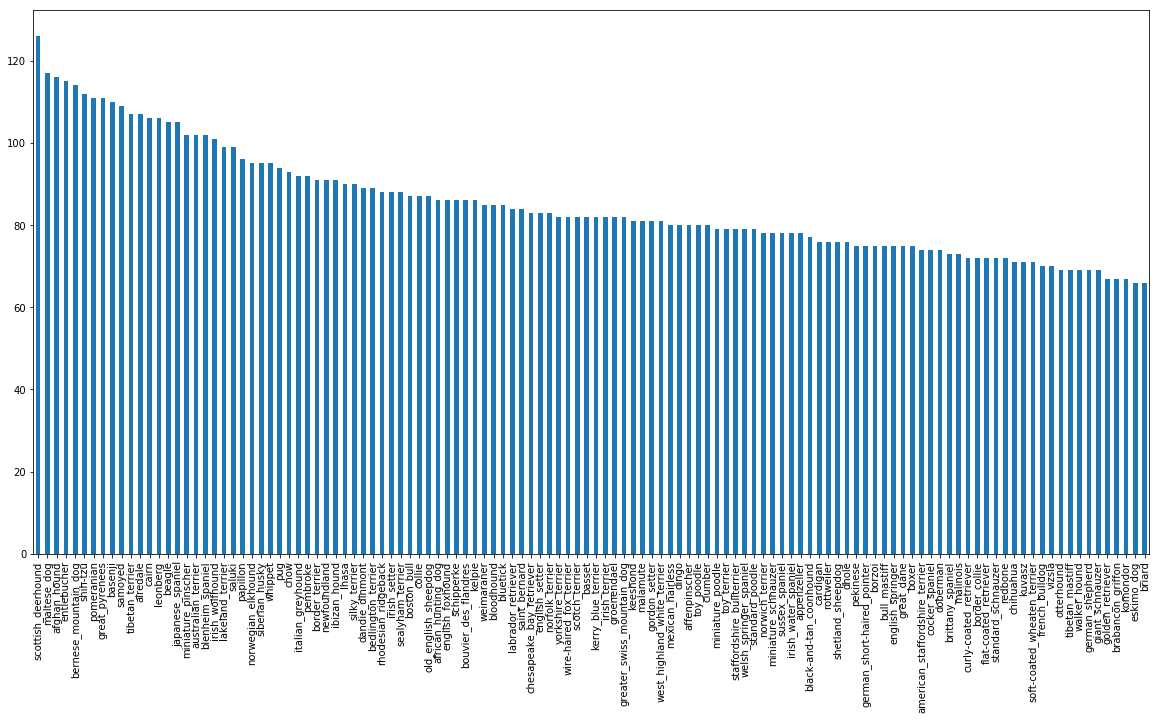

In [5]:
labels['breed'].value_counts().plot(kind='bar', figsize=(20,10))

### list of 120 categories (full dataset)

In [7]:
#alphabetical list of breeds
alpha_breed_list = list(labels['breed'].value_counts().index.sort_values('breed')[0])
alpha_breed_list[:5]

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier']

### list of top 10 categories (sample dataset for testing)

In [8]:
top_ten_cat = list(labels['breed'].value_counts().index[0:10])
top_ten_cat

['scottish_deerhound',
 'maltese_dog',
 'afghan_hound',
 'entlebucher',
 'bernese_mountain_dog',
 'shih-tzu',
 'pomeranian',
 'great_pyrenees',
 'basenji',
 'samoyed']

## 1.2. Make directories / copy and move files 

### make directories : /valid --- /results --- /sample/train ---  /sample/valid

In [9]:
if not os.path.exists(DATA_HOME_DIR + '/valid/'): os.mkdir(DATA_HOME_DIR + '/valid/')
if not os.path.exists(DATA_HOME_DIR + '/results/'): os.mkdir(DATA_HOME_DIR + '/results/')
if not os.path.exists(DATA_HOME_DIR + '/sample/'): os.mkdir(DATA_HOME_DIR + '/sample/')
if not os.path.exists(DATA_HOME_DIR + '/sample/train/'): os.mkdir(DATA_HOME_DIR + '/sample/train/')
if not os.path.exists(DATA_HOME_DIR + '/sample/test/'): os.mkdir(DATA_HOME_DIR + '/sample/test/')
if not os.path.exists(DATA_HOME_DIR + '/sample/valid/'): os.mkdir(DATA_HOME_DIR + '/sample/valid/')
if not os.path.exists(DATA_HOME_DIR + '/sample/results/'): os.mkdir(DATA_HOME_DIR + '/sample/results/')

### move 10% of /train to /valid

In [16]:
from glob import glob

In [15]:
%cd $DATA_HOME_DIR/train
g = glob('*.jpg')
shuf = np.random.permutation(g)

#first 10% of shuffled files
valid_samples = shuf[:len(shuf)//10]
train_samples = shuf[len(shuf)//10:]

#lists of train and valid image IDs
valid_samples_id = [valid_samples[i][:-4] for i in range(len(valid_samples))]
train_samples_id = [train_samples[i][:-4] for i in range(len(train_samples))]

#dataFrames containing train_samples and valid_samples
labels_train = labels[labels['id'].isin(train_samples_id)]
labels_valid = labels[labels['id'].isin(valid_samples_id)]

/home/gael/Bureau/kaggle/dog-breed-identification/data/train


array([], dtype=float64)

In [16]:
import shutil
from shutil import move, copyfile

for i in range (len(shuf)//10):
    shutil.move(shuf[i], DATA_HOME_DIR + '/valid/' + shuf[i])

%ls $DATA_HOME_DIR/train | wc -l #check number of directories

### create 120 category subdirectories in /train and /valid

In [30]:
#create directories for ea. subcategory
for i in range(len(alpha_breed_list)):
    if not os.path.exists(DATA_HOME_DIR + '/train/' + alpha_breed_list[i]): 
        os.mkdir(DATA_HOME_DIR + '/train/' + alpha_breed_list[i])
    if not os.path.exists(DATA_HOME_DIR + '/valid/' + alpha_breed_list[i]): 
        os.mkdir(DATA_HOME_DIR + '/valid/' + alpha_breed_list[i])

### move files in their category directories 

In [31]:
%cd $DATA_HOME_DIR/train

#put each image from training set in its category
for i in range(len(labels_train.index)):
    shutil.move(labels_train.values[i][0]+'.jpg', './'+labels_train.values[i][1]+'/'+labels_train.values[i][0]+'.jpg')

%cd $DATA_HOME_DIR/valid

#put each image from valid set in its category
for i in range(len(labels_valid.index)):
    shutil.move(labels_valid.values[i][0]+'.jpg', './'+labels_valid.values[i][1]+'/'+labels_valid.values[i][0]+'.jpg')

/home/gael/Bureau/kaggle/dog-breed-identification/data/train


### make test/unknown directory, move test files

In [38]:
%cd $DATA_HOME_DIR/test
if not os.path.exists(DATA_HOME_DIR + '/test/unknown/'): 
        os.mkdir(DATA_HOME_DIR + '/test/unknown/')
%cd $DATA_HOME_DIR/test/unknown
!mv $DATA_HOME_DIR/test/*.jpg .

## Copy sample files

### copy top10 categories directories to /sample/train and /sample/valid 

In [35]:
from distutils.dir_util import copy_tree

In [36]:
%cd $DATA_HOME_DIR/train

for i in range(len(top_ten_cat[:10])):
    copy_tree(DATA_HOME_DIR + '/train/' + top_ten_cat[i], DATA_HOME_DIR + '/sample/train/' + top_ten_cat[i])
    copy_tree(DATA_HOME_DIR + '/valid/' + top_ten_cat[i], DATA_HOME_DIR + '/sample/valid/' + top_ten_cat[i])

/home/gael/Bureau/kaggle/dog-breed-identification/data/train


### copy 10% of test/unknown into sample/test/unknown 

In [120]:
%cd $DATA_HOME_DIR/test/unknown
g = glob('*.jpg')
shuf = np.random.permutation(g)

/home/gael/Bureau/kaggle/dog-breed-identification/data/test/unknown


array(['efc4b489fc15ff97a50536c71029a8b1.jpg',
       '88242e567162bf2218c0b138d0257674.jpg',
       '7046540577c4b66cf19936231d391b8e.jpg', ...,
       'e86bb44f11c953a6d69c548e756f5a3b.jpg',
       '283109fef09eb536e61f334e6945c7eb.jpg',
       '7df691c589c68c35132732e17ccb71ce.jpg'],
      dtype='|S36')

In [122]:
if not os.path.exists(DATA_HOME_DIR + '/sample/test/unknown/'): 
        os.mkdir(DATA_HOME_DIR + '/sample/test/unknown/')

#first 10% of shuffled files
test_samples = shuf[:len(shuf)//10]

%cd $DATA_HOME_DIR/test/unknown
for i in range (len(shuf)//10):
    shutil.copyfile(shuf[i], DATA_HOME_DIR + '/sample/test/unknown/' + shuf[i])

## 1.3. Paths

In [6]:
%cd $DATA_HOME_DIR

/home/gael/Bureau/kaggle/dog-breed-identification/data


In [7]:
# --- full dataset ---
#path, test_path, output_dim = DATA_HOME_DIR + '/', DATA_HOME_DIR +'/test/', 120

# --- sample dataset ---
path, test_path, output_dim = DATA_HOME_DIR + "/sample/", DATA_HOME_DIR +'/sample/test/', 10

model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [8]:
model_path

'/home/gael/Bureau/kaggle/dog-breed-identification/data/sample/models/'

# 2. Utils

In [9]:
def get_batches(image_dim, batch_size = 1, class_mode = None, shuffle = False):
    
    def get_batch(path, image_dim, batch_size, class_mode, shuffle):
        datagen = ImageDataGenerator()
        batch = datagen.flow_from_directory(
            path,
            target_size = (image_dim, image_dim), #(224,224) or (299,299)
            batch_size = batch_size,
            class_mode = class_mode,
            shuffle = shuffle)
        return batch

    train_batches = get_batch(path + 'train', image_dim, batch_size, class_mode, shuffle)
    valid_batches = get_batch(path + 'valid', image_dim, batch_size, class_mode, shuffle)
    test_batches = get_batch(test_path, image_dim, batch_size, class_mode, shuffle)

    return train_batches, valid_batches, test_batches

In [10]:
def write_submission_file(test_probs, model_name, clip_value):
    filenames_df = pd.DataFrame(test_batches.filenames)
    #remove 'unknown/' and '.jpg' from filenames strings
    filenames_extracts = []
    for i in range(len(filenames_df)): filenames_df[0][i] = filenames_df[0][i][filenames_df[0][i].find('/') + 1:-4]

    probs_df = pd.DataFrame(test_probs)
    probs_df_clip = probs_df.clip(clip_value, 1 - clip_value)
    subm_df = pd.concat([filenames_df, probs_df_clip], axis=1)
    header = train_batches.class_indices.keys()
    header = sorted(header)#.sort()
    header.insert(0,'id')
    subm_df.columns = header
    subm_df = subm_df.sort_values(by='id')
    %cd $HOME_DIR 
    subm_df.to_csv('submission_'+model_name+'.csv', sep=',', index = False, float_format='%.17f')

# 3. 224x224 models : VGG16, ResNet

## 3.1. Use VGG16 max pooling layer to find dogs

In [11]:
batch_size = 16

input_tensor = Input(shape=(224, 224, 3)) #TF backend

In [12]:
conv_model = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor, pooling = 'avg')

l = conv_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], [l[-2].output]) #returns output from l[-2] given input in l[0]

We need batches of (224,224) images to use VGG16

In [13]:
train_batches, valid_batches, test_batches = get_batches(224)

Found 1021 images belonging to 10 classes.
Found 120 images belonging to 10 classes.
Found 1035 images belonging to 1 classes.


In [37]:
train_data_1 = np.concatenate([train_batches.next() for i in tqdm(range(0,train_batches.n//5))])
train_data_2 = np.concatenate([train_batches.next() for i in tqdm(range(train_batches.n//5,2*train_batches.n//5))])
train_data_3 = np.concatenate([train_batches.next() for i in tqdm(range(2*train_batches.n//5,3*train_batches.n//5))])
train_data_4 = np.concatenate([train_batches.next() for i in tqdm(range(3*train_batches.n//5,4*train_batches.n//5))])
train_data_5 = np.concatenate([train_batches.next() for i in tqdm(range(4*train_batches.n//5,train_batches.n))])
train_data = np.concatenate((train_data_1, train_data_2, train_data_3, train_data_4, train_data_5))
train_data = vgg16.preprocess_input(train_data)

100%|██████████| 205/205 [00:00<00:00, 293.67it/s]


In [38]:
valid_data_1 = np.concatenate([valid_batches.next() for i in tqdm(range(0,valid_batches.n//5))])
valid_data_2 = np.concatenate([valid_batches.next() for i in tqdm(range(valid_batches.n//5,2*valid_batches.n//5))])
valid_data_3 = np.concatenate([valid_batches.next() for i in tqdm(range(2*valid_batches.n//5,3*valid_batches.n//5))])
valid_data_4 = np.concatenate([valid_batches.next() for i in tqdm(range(3*valid_batches.n//5,4*valid_batches.n//5))])
valid_data_5 = np.concatenate([valid_batches.next() for i in tqdm(range(4*valid_batches.n//5,valid_batches.n))])
valid_data = np.concatenate((valid_data_1, valid_data_2, valid_data_3, valid_data_4, valid_data_5))
valid_data = vgg16.preprocess_input(valid_data)

100%|██████████| 24/24 [00:00<00:00, 273.04it/s]


In [39]:
test_data_1 = np.concatenate([test_batches.next() for i in tqdm(range(0,test_batches.n//5))])
test_data_2 = np.concatenate([test_batches.next() for i in tqdm(range(test_batches.n//5,2*test_batches.n//5))])
test_data_3 = np.concatenate([test_batches.next() for i in tqdm(range(2*test_batches.n//5,3*test_batches.n//5))])
test_data_4 = np.concatenate([test_batches.next() for i in tqdm(range(3*test_batches.n//5,4*test_batches.n//5))])
test_data_5 = np.concatenate([test_batches.next() for i in tqdm(range(4*test_batches.n//5,test_batches.n))])
test_data = np.concatenate((test_data_1, test_data_2, test_data_3, test_data_4, test_data_5))
test_data = vgg16.preprocess_input(test_data)

100%|██████████| 207/207 [00:00<00:00, 265.72it/s]


In [15]:
valid_labels = to_categorical(valid_batches.classes, num_classes=output_dim)
train_labels = to_categorical(train_batches.classes, num_classes=output_dim)

In [16]:
def get_crop_data_proportions(batch_data, threshold = 0.3):
    
    number_of_images = batch_data.shape[0]
    input_dim = batch_data.shape[1]
    #cropped_data = np.zeros((number_of_images, input_dim, input_dim, 3))
    crop_proportions = []
    
    for image_idx in tqdm(range(number_of_images)):
    #for image_idx in range(number_of_images):
    #We have to add an extra dimension to our input since the CNN expects a 'batch' (even if it's just a batch of one).
        inp = np.expand_dims(batch_data[image_idx], 0)
    
        # colormap of last max pooling layer
        cm = conv_fn([inp,0])[0]
        resized_pool_layer = scipy.misc.imresize(np.sum(cm[0], axis = 2), (input_dim, input_dim))#, interp='nearest')
    
        # position of maximum in colormap
        max_pos_vert = np.where(resized_pool_layer == np.max(resized_pool_layer))[0][0]
        max_pos_horiz = np.where(resized_pool_layer == np.max(resized_pool_layer))[1][0]
    
        # lineouts across maximum 
        horiz_lineout = resized_pool_layer[max_pos_vert,:]
        vert_lineout = resized_pool_layer[:,max_pos_horiz]
        
        # define bounding box around maximum intensity of max pooling layer
        threshold = threshold # for selecting bounding box around maximum

        horiz_right = max_pos_horiz 
        while horiz_right < input_dim :
            if (horiz_lineout[horiz_right] < np.int(threshold*np.max(horiz_lineout)) ): break
            horiz_right += 1
        horiz_left = max_pos_horiz
        while horiz_left > 0:
            if (horiz_lineout[horiz_left] < np.int(threshold*np.max(horiz_lineout)) ): break
            horiz_left -= 1
        
        max_pos_vert = np.where(vert_lineout == np.max(vert_lineout))[0][0]
        vert_top = max_pos_vert 
        while vert_top > 0:
            if (vert_lineout[vert_top] < np.int(threshold*np.max(vert_lineout)) ): break
            vert_top -= 1
        vert_bottom = max_pos_vert
        while vert_bottom < input_dim:
            if (vert_lineout[vert_bottom] < np.int(threshold*np.max(vert_lineout)) ): break            
            vert_bottom += 1
        
        # cropped image
        #batch_data_mod = batch_data[image_idx][vert_top:vert_bottom,horiz_left:horiz_right]
        
        crop_proportions.append((image_idx, 1.0*vert_top/input_dim, 1.0*vert_bottom/input_dim, \
                                       1.0*horiz_left/input_dim, 1.0*horiz_right/input_dim))
    
    return crop_proportions

In [50]:
valid_crop_proportions_1 = get_crop_data_proportions(valid_data[0:len(valid_data)//5], threshold = 0.3)
valid_crop_proportions_2 = get_crop_data_proportions(valid_data[len(valid_data)//5:2*len(valid_data)//5], threshold = 0.3)
valid_crop_proportions_3 = get_crop_data_proportions(valid_data[2*len(valid_data)//5:3*len(valid_data)//5], threshold = 0.3)
valid_crop_proportions_4 = get_crop_data_proportions(valid_data[3*len(valid_data)//5:4*len(valid_data)//5], threshold = 0.3)
valid_crop_proportions_5 = get_crop_data_proportions(valid_data[4*len(valid_data)//5:len(valid_data)], threshold = 0.3)
valid_crop_proportions = np.concatenate((valid_crop_proportions_1, valid_crop_proportions_2, valid_crop_proportions_3, valid_crop_proportions_4, valid_crop_proportions_5))

100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


In [51]:
train_crop_proportions_1 = get_crop_data_proportions(train_data[0:len(train_data)//5], threshold = 0.3)
train_crop_proportions_2 = get_crop_data_proportions(train_data[len(train_data)//5:2*len(train_data)//5], threshold = 0.3)
train_crop_proportions_3 = get_crop_data_proportions(train_data[2*len(train_data)//5:3*len(train_data)//5], threshold = 0.3)
train_crop_proportions_4 = get_crop_data_proportions(train_data[3*len(train_data)//5:4*len(train_data)//5], threshold = 0.3)
train_crop_proportions_5 = get_crop_data_proportions(train_data[4*len(train_data)//5:len(train_data)], threshold = 0.3)
train_crop_proportions = np.concatenate((train_crop_proportions_1, train_crop_proportions_2, train_crop_proportions_3, train_crop_proportions_4, train_crop_proportions_5))

100%|██████████| 205/205 [02:41<00:00,  1.27it/s]


In [71]:
test_crop_proportions_1 = get_crop_data_proportions(test_data[0:len(test_data)//5], threshold = 0.3)
test_crop_proportions_2 = get_crop_data_proportions(test_data[len(test_data)//5:2*len(test_data)//5], threshold = 0.3)
test_crop_proportions_3 = get_crop_data_proportions(test_data[2*len(test_data)//5:3*len(test_data)//5], threshold = 0.3)
test_crop_proportions_4 = get_crop_data_proportions(test_data[3*len(test_data)//5:4*len(test_data)//5], threshold = 0.3)
test_crop_proportions_5 = get_crop_data_proportions(test_data[4*len(test_data)//5:len(test_data)], threshold = 0.3)
test_crop_proportions = np.concatenate((test_crop_proportions_1, test_crop_proportions_2, test_crop_proportions_3, test_crop_proportions_4, test_crop_proportions_5))

100%|██████████| 207/207 [02:51<00:00,  1.21it/s]


In [22]:
np.save('valid_crop_proportions.npy', valid_crop_proportions)
np.save('train_crop_proportions.npy', train_crop_proportions)
np.save('test_crop_proportions.npy', test_crop_proportions)

In [18]:
valid_crop_proportions = np.load('valid_crop_proportions.npy')
train_crop_proportions = np.load('train_crop_proportions.npy')
test_crop_proportions = np.load('test_crop_proportions.npy')

- Re-generate batches with larger size (500, 500) in order not to lose resolution in the cropped images
- Use crop_proportions to crop images around dog
- Resize cropped images to (224, 224) for use w/ VGG or Resnet

In [58]:
train_batches_500, valid_batches_500, test_batches_500 = get_batches(500)#(224)

Found 1021 images belonging to 10 classes.
Found 120 images belonging to 10 classes.
Found 1035 images belonging to 1 classes.


In [34]:
train_data_500_1 = np.concatenate([train_batches_500.next() for i in tqdm(range(0,train_batches_500.n//5))])
train_data_500_2 = np.concatenate([train_batches_500.next() for i in tqdm(range(train_batches_500.n//5,2*train_batches_500.n//5))])
train_data_500_3 = np.concatenate([train_batches_500.next() for i in tqdm(range(2*train_batches_500.n//5,3*train_batches_500.n//5))])
train_data_500_4 = np.concatenate([train_batches_500.next() for i in tqdm(range(3*train_batches_500.n//5,4*train_batches_500.n//5))])
train_data_500_5 = np.concatenate([train_batches_500.next() for i in tqdm(range(4*train_batches_500.n//5,train_batches_500.n))])
train_data_500 = np.concatenate((train_data_500_1, train_data_500_2, train_data_500_3, train_data_500_4, train_data_500_5))

100%|██████████| 205/205 [00:01<00:00, 198.62it/s]


In [35]:
valid_data_500_1 = np.concatenate([valid_batches_500.next() for i in tqdm(range(0,valid_batches_500.n//5))])
valid_data_500_2 = np.concatenate([valid_batches_500.next() for i in tqdm(range(valid_batches_500.n//5,2*valid_batches_500.n//5))])
valid_data_500_3 = np.concatenate([valid_batches_500.next() for i in tqdm(range(2*valid_batches_500.n//5,3*valid_batches_500.n//5))])
valid_data_500_4 = np.concatenate([valid_batches_500.next() for i in tqdm(range(3*valid_batches_500.n//5,4*valid_batches_500.n//5))])
valid_data_500_5 = np.concatenate([valid_batches_500.next() for i in tqdm(range(4*valid_batches_500.n//5,valid_batches_500.n))])
valid_data_500 = np.concatenate((valid_data_500_1, valid_data_500_2, valid_data_500_3, valid_data_500_4, valid_data_500_5))

100%|██████████| 24/24 [00:00<00:00, 84.16it/s]


In [32]:
test_data_500_1 = np.concatenate([test_batches_500.next() for i in tqdm(range(0,test_batches_500.n//5))])
test_data_500_2 = np.concatenate([test_batches_500.next() for i in tqdm(range(test_batches_500.n//5,2*test_batches_500.n//5))])
test_data_500_3 = np.concatenate([test_batches_500.next() for i in tqdm(range(2*test_batches_500.n//5,3*test_batches_500.n//5))])
test_data_500_4 = np.concatenate([test_batches_500.next() for i in tqdm(range(3*test_batches_500.n//5,4*test_batches_500.n//5))])
test_data_500_5 = np.concatenate([test_batches_500.next() for i in tqdm(range(4*test_batches_500.n//5,test_batches_500.n))])
test_data_500 = np.concatenate((test_data_500_1, test_data_500_2, test_data_500_3, test_data_500_4, test_data_500_5))

100%|██████████| 207/207 [00:00<00:00, 214.28it/s]


In [33]:
test_data_500_1.shape, test_data_500_2.shape, test_data_500.shape

((207, 500, 500, 3), (207, 500, 500, 3), (1035, 500, 500, 3))

In [ ]:
valid_data_500.shape

Crop data using crop proportions calculated earlier and resize to (output_dim, output_dim)

In [59]:
def get_cropped_data(batch_data, batch_data_crop_proportions, output_dim = 224):

    number_of_images = batch_data.shape[0]
    input_dim = batch_data.shape[1]
    
    cropped_data = np.zeros((number_of_images, output_dim, output_dim, 3))

    for image_idx in tqdm(range(number_of_images)):
    #for image_idx in range(number_of_images):
        vert_top = int(batch_data_crop_proportions[image_idx][1]*input_dim)
        vert_bottom = int(batch_data_crop_proportions[image_idx][2]*input_dim)
        horiz_left = int(batch_data_crop_proportions[image_idx][3]*input_dim)
        horiz_right = int(batch_data_crop_proportions[image_idx][4]*input_dim)
    
        # cropped image
        batch_data_mod = batch_data[image_idx][vert_top:vert_bottom, horiz_left:horiz_right]
        
        #resize cropped image for use with models
        cropped_data[image_idx] = scipy.misc.imresize(batch_data_mod, (output_dim, output_dim))
            
    return cropped_data    

In [69]:
valid_data_cropped_299_1 = get_cropped_data(valid_data_500[0:len(valid_data)//5], \
                                    valid_crop_proportions[0:len(valid_data)//5], output_dim = 299)
valid_data_cropped_299_2 = get_cropped_data(valid_data_500[len(valid_data)//5:2*len(valid_data)//5], \
                                    valid_crop_proportions[len(valid_data)//5:2*len(valid_data)//5], output_dim = 299)
valid_data_cropped_299_3 = get_cropped_data(valid_data_500[2*len(valid_data)//5:3*len(valid_data)//5],\
                                    valid_crop_proportions[2*len(valid_data)//5:3*len(valid_data)//5], output_dim = 299)
valid_data_cropped_299_4 = get_cropped_data(valid_data_500[3*len(valid_data)//5:4*len(valid_data)//5], \
                                    valid_crop_proportions[3*len(valid_data)//5:4*len(valid_data)//5], output_dim = 299)
valid_data_cropped_299_5 = get_cropped_data(valid_data_500[4*len(valid_data)//5:len(valid_data)], \
                                    valid_crop_proportions[4*len(valid_data)//5:len(valid_data)], output_dim = 299)

valid_data_cropped_299 = np.concatenate((valid_data_cropped_299_1, valid_data_cropped_299_2, valid_data_cropped_299_3,\
                                         valid_data_cropped_299_4, valid_data_cropped_299_5))

100%|██████████| 24/24 [00:00<00:00, 272.18it/s]


In [72]:
train_data_cropped_299_1 = get_cropped_data(train_data_500[0:len(train_data)//5], \
                                    train_crop_proportions[0:len(train_data)//5], output_dim = 299)
train_data_cropped_299_2 = get_cropped_data(train_data_500[len(train_data)//5:2*len(train_data)//5], \
                                    train_crop_proportions[len(train_data)//5:2*len(train_data)//5], output_dim = 299)
train_data_cropped_299_3 = get_cropped_data(train_data_500[2*len(train_data)//5:3*len(train_data)//5],\
                                    train_crop_proportions[2*len(train_data)//5:3*len(train_data)//5], output_dim = 299)
train_data_cropped_299_4 = get_cropped_data(train_data_500[3*len(train_data)//5:4*len(train_data)//5], \
                                    train_crop_proportions[3*len(train_data)//5:4*len(train_data)//5], output_dim = 299)
train_data_cropped_299_5 = get_cropped_data(train_data_500[4*len(train_data)//5:len(train_data)], \
                                    train_crop_proportions[4*len(train_data)//5:len(train_data)], output_dim = 299)

train_data_cropped_299 = np.concatenate((train_data_cropped_299_1, train_data_cropped_299_2, train_data_cropped_299_3,\
                                         train_data_cropped_299_4, train_data_cropped_299_5))

100%|██████████| 205/205 [00:01<00:00, 171.82it/s]


In [73]:
test_data_cropped_299_1 = get_cropped_data(test_data_500[0:len(test_data)//5], \
                                    test_crop_proportions[0:len(test_data)//5], output_dim = 299)
test_data_cropped_299_2 = get_cropped_data(test_data_500[len(test_data)//5:2*len(test_data)//5], \
                                    test_crop_proportions[len(test_data)//5:2*len(test_data)//5], output_dim = 299)
test_data_cropped_299_3 = get_cropped_data(test_data_500[2*len(test_data)//5:3*len(test_data)//5],\
                                    test_crop_proportions[2*len(test_data)//5:3*len(test_data)//5], output_dim = 299)
test_data_cropped_299_4 = get_cropped_data(test_data_500[3*len(test_data)//5:4*len(test_data)//5], \
                                    test_crop_proportions[3*len(test_data)//5:4*len(test_data)//5], output_dim = 299)
test_data_cropped_299_5 = get_cropped_data(test_data_500[4*len(test_data)//5:len(test_data)], \
                                    test_crop_proportions[4*len(test_data)//5:len(test_data)], output_dim = 299)

test_data_cropped_299 = np.concatenate((test_data_cropped_299_1, test_data_cropped_299_2, test_data_cropped_299_3,\
                                         test_data_cropped_299_4, test_data_cropped_299_5))

100%|██████████| 207/207 [00:04<00:00, 43.29it/s]


In [74]:
valid_data_cropped_299 = xception.preprocess_input(valid_data_cropped_299)
train_data_cropped_299 = xception.preprocess_input(train_data_cropped_299)
test_data_cropped_299 = xception.preprocess_input(test_data_cropped_299)

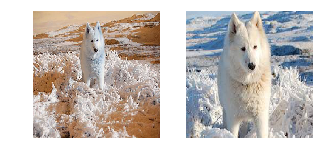

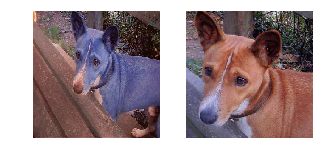

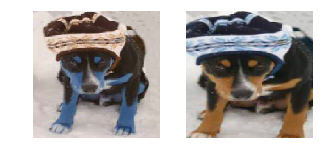

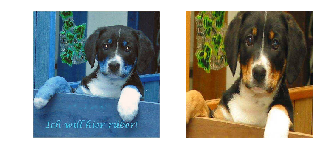

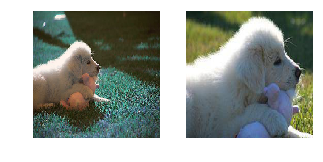

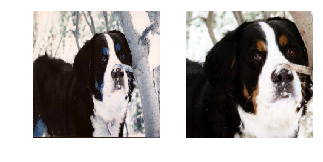

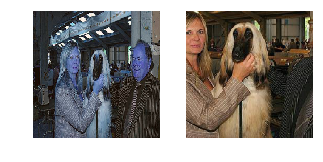

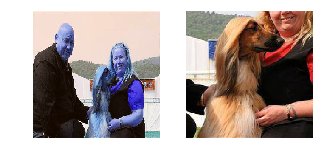

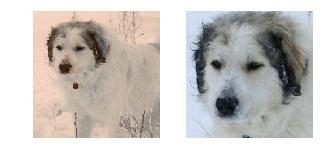

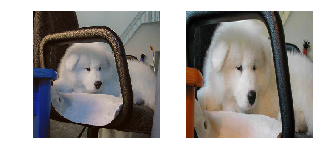

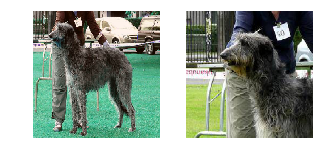

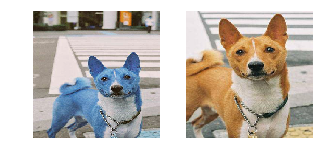

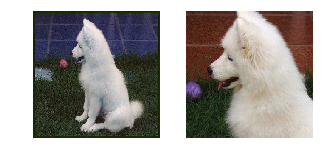

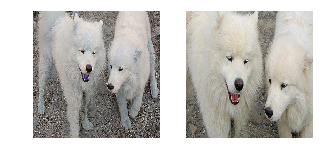

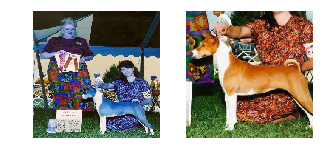

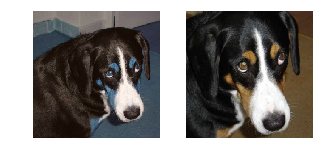

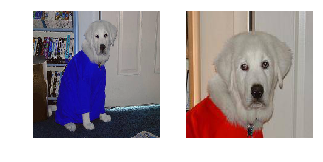

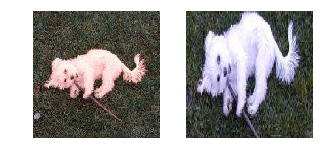

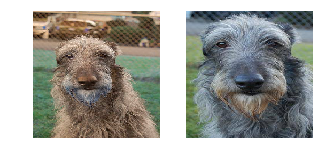

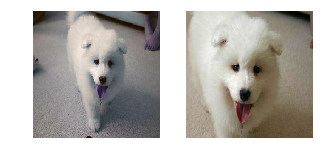

In [75]:
num_displayed_images = 20
for image_idx in range(num_displayed_images):
    rand_idx = np.random.choice(1000)
    fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize=(5,5))
    ax0.imshow((train_data[rand_idx] - np.min(train_data[rand_idx]))/np.max(train_data[rand_idx] - np.min(train_data[rand_idx])))
    ax0.axis('off')
    ax1.imshow((train_data_cropped_299[rand_idx] - np.min(train_data_cropped_299[rand_idx]))/np.max(train_data_cropped_299[rand_idx] - np.min(train_data_cropped_299[rand_idx])))
    ax1.axis('off')

---

# 4. 299x299 models

In [76]:
#train_batches, valid_batches, test_batches = get_batches(299)
input_tensor = Input(shape=(299, 299, 3))

## 4.1. Inception

In [77]:
conv_model_inception_v3 = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_tensor,
                                                   pooling = 'avg')

In [85]:
batch_size = 4

In [86]:
incept_bottleneck_features_train_cropped = conv_model_inception_v3.predict(train_data_cropped_299, batch_size=batch_size) # 480 s
incept_bottleneck_features_valid_cropped = conv_model_inception_v3.predict(valid_data_cropped_299, batch_size=batch_size)

In [88]:
np.save('incept_bottleneck_features_train_cropped.npy', incept_bottleneck_features_train_cropped)
np.save('incept_bottleneck_features_valid_cropped.npy', incept_bottleneck_features_valid_cropped)

In [126]:
opt = Adam(1e-4)

In [151]:
top_model = Sequential([
        Dense(output_dim, activation='softmax',input_shape = incept_bottleneck_features_train_cropped.shape[1:])
        ])
top_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [152]:
batch_size = 1

In [153]:
history_inception = top_model.fit(incept_bottleneck_features_train_cropped, train_labels, epochs = 100, batch_size = batch_size,  
                 validation_data = (incept_bottleneck_features_valid_cropped, valid_labels))#, callbacks=[EarlyStopping(patience = 4, monitor='val_loss')])

Train on 1021 samples, validate on 120 samples
Epoch 1/100
1021/1021 [==============================] - 2s - loss: 0.3544 - acc: 0.9393 - val_loss: 0.0826 - val_acc: 0.9917
Epoch 2/100
1021/1021 [==============================] - 1s - loss: 0.0841 - acc: 0.9833 - val_loss: 0.0392 - val_acc: 0.9917
Epoch 3/100
1021/1021 [==============================] - 1s - loss: 0.0602 - acc: 0.9853 - val_loss: 0.0275 - val_acc: 1.0000
Epoch 4/100
1021/1021 [==============================] - 1s - loss: 0.0460 - acc: 0.9902 - val_loss: 0.0217 - val_acc: 1.0000
Epoch 5/100
1021/1021 [==============================] - 1s - loss: 0.0367 - acc: 0.9902 - val_loss: 0.0165 - val_acc: 1.0000
Epoch 6/100
1021/1021 [==============================] - 1s - loss: 0.0302 - acc: 0.9931 - val_loss: 0.0210 - val_acc: 1.0000
Epoch 7/100
1021/1021 [==============================] - 1s - loss: 0.0261 - acc: 0.9951 - val_loss: 0.0136 - val_acc: 1.0000
Epoch 8/100
1021/1021 [==============================] - 1s - loss: 0.0

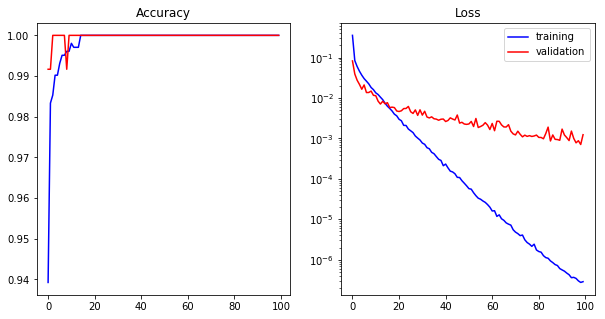

In [173]:
acc = history_inception.history['acc']
val_acc = history_inception.history['val_acc']
loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']
epochs = history_inception.epoch

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
ax = axes[0]
ax.plot(epochs, acc, 'b')
ax.plot(epochs, val_acc, 'r')
ax.set_title("Accuracy")

ax = axes[1]
ax.semilogy(epochs, loss, 'b', label = 'training')
ax.semilogy(epochs, val_loss, 'r', label = 'validation')
ax.set_title("Loss")
ax.legend(loc='upper right')

plt.show()

### predictions

In [102]:
incept_bottleneck_features_test_cropped = conv_model_inception_v3.predict(test_data_cropped_299, batch_size=batch_size)

In [103]:
# predicted classes
incept_test_preds = top_model.predict_classes(incept_bottleneck_features_test_cropped, batch_size=batch_size)
incept_valid_preds = top_model.predict_classes(incept_bottleneck_features_valid_cropped, batch_size=batch_size)

# probabilities of being in a given class
incept_test_probs = top_model.predict_proba(incept_bottleneck_features_test_cropped, batch_size=batch_size)
incept_valid_probs = top_model.predict_proba(incept_bottleneck_features_valid_cropped, batch_size=batch_size)

 92/120 [======================>.......] - ETA: 0s

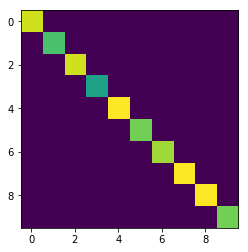

In [104]:
cm = confusion_matrix(incept_valid_preds, valid_batches.classes)
plt.imshow(cm)

In [185]:
write_submission_file(test_probs=incept_test_probs,model_name='Inception', clip_value=0.0)

/home/gael/Bureau/kaggle/dog-breed-identification


## 4.2. Xception

In [155]:
conv_model_xception = xception.Xception(include_top=False, weights='imagenet', input_tensor=input_tensor,
                                       pooling = 'avg')

In [156]:
batch_size = 4

In [162]:
xception_bottleneck_features_train_cropped = conv_model_xception.predict(train_data_cropped_299, batch_size=batch_size) # 900 s
xception_bottleneck_features_valid_cropped = conv_model_xception.predict(valid_data_cropped_299, batch_size=batch_size)
#xception_bottleneck_features_test_cropped = conv_model_xception.predict(test_data_cropped_299, batch_size=batch_size)

In [164]:
np.save('xception_bottleneck_features_train_cropped.npy', xception_bottleneck_features_train_cropped)
np.save('xception_bottleneck_features_valid_cropped.npy', xception_bottleneck_features_valid_cropped)
#np.save('xception_bottleneck_features_test_cropped.npy', xception_bottleneck_features_test_cropped)

In [165]:
xception_bottleneck_features_train_cropped = np.load('xception_bottleneck_features_train_cropped.npy')
xception_bottleneck_features_valid_cropped = np.load('xception_bottleneck_features_valid_cropped.npy')

### Dense layer on top of xception features 

In [166]:
#opt = Adam(1e-4)
opt= RMSprop(1e-4)

In [167]:
top_model = Sequential([
        Dense(output_dim, activation='softmax',input_shape = xception_bottleneck_features_train_cropped.shape[1:])
        ])
top_model.compile(optimizer= opt , loss='categorical_crossentropy', metrics=['accuracy'])

In [168]:
batch_size = 48

In [169]:
history_xception = top_model.fit(xception_bottleneck_features_train_cropped, train_labels, epochs = 200, 
                                 batch_size = batch_size, 
                                validation_data = (xception_bottleneck_features_valid_cropped, valid_labels))

Train on 1021 samples, validate on 120 samples
Epoch 1/200
1021/1021 [==============================] - 0s - loss: 2.1321 - acc: 0.3898 - val_loss: 1.9695 - val_acc: 0.5583
Epoch 2/200
1021/1021 [==============================] - 0s - loss: 1.8189 - acc: 0.7189 - val_loss: 1.6918 - val_acc: 0.8583
Epoch 3/200
1021/1021 [==============================] - 0s - loss: 1.5608 - acc: 0.9040 - val_loss: 1.4415 - val_acc: 0.9750
Epoch 4/200
1021/1021 [==============================] - 0s - loss: 1.3263 - acc: 0.9628 - val_loss: 1.2140 - val_acc: 0.9917
Epoch 5/200
1021/1021 [==============================] - 0s - loss: 1.1139 - acc: 0.9755 - val_loss: 1.0120 - val_acc: 0.9917
Epoch 6/200
1021/1021 [==============================] - 0s - loss: 0.9288 - acc: 0.9775 - val_loss: 0.8379 - val_acc: 0.9917
Epoch 7/200
1021/1021 [==============================] - 0s - loss: 0.7710 - acc: 0.9833 - val_loss: 0.6873 - val_acc: 0.9917
Epoch 8/200
1021/1021 [==============================] - 0s - loss: 0.6

1021/1021 [==============================] - 0s - loss: 0.0103 - acc: 0.9980 - val_loss: 0.0075 - val_acc: 1.0000
Epoch 130/200
1021/1021 [==============================] - 0s - loss: 0.0101 - acc: 0.9980 - val_loss: 0.0075 - val_acc: 1.0000
Epoch 131/200
1021/1021 [==============================] - 0s - loss: 0.0100 - acc: 0.9980 - val_loss: 0.0074 - val_acc: 1.0000
Epoch 132/200
1021/1021 [==============================] - 0s - loss: 0.0099 - acc: 0.9980 - val_loss: 0.0072 - val_acc: 1.0000
Epoch 133/200
1021/1021 [==============================] - 0s - loss: 0.0097 - acc: 0.9980 - val_loss: 0.0072 - val_acc: 1.0000
Epoch 134/200
1021/1021 [==============================] - 0s - loss: 0.0097 - acc: 0.9980 - val_loss: 0.0072 - val_acc: 1.0000
Epoch 135/200
1021/1021 [==============================] - 0s - loss: 0.0095 - acc: 0.9980 - val_loss: 0.0071 - val_acc: 1.0000
Epoch 136/200
1021/1021 [==============================] - 0s - loss: 0.0094 - acc: 0.9980 - val_loss: 0.0070 - val_ac

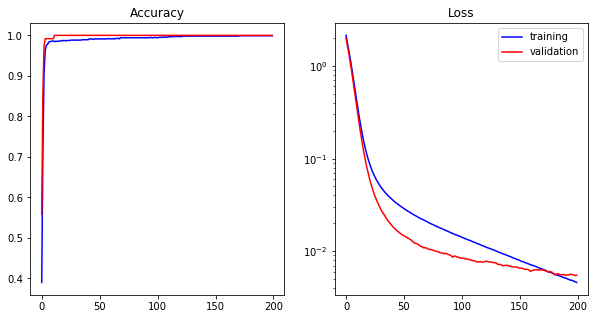

In [172]:
acc = history_xception.history['acc']
val_acc = history_xception.history['val_acc']
loss = history_xception.history['loss']
val_loss = history_xception.history['val_loss']
epochs = history_xception.epoch

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
ax = axes[0]
ax.plot(epochs, acc, 'b')
ax.plot(epochs, val_acc, 'r')
ax.set_title("Accuracy")

ax = axes[1]
ax.semilogy(epochs, loss, 'b', label = 'training')
ax.semilogy(epochs, val_loss, 'r', label = 'validation')
ax.set_title("Loss")
ax.legend(loc='upper right')

plt.show()

### predictions

In [174]:
xception_bottleneck_features_test_cropped = conv_model_xception.predict(test_data_cropped_299, batch_size=batch_size)

In [175]:
# predicted classes
xc_test_preds = top_model.predict_classes(xception_bottleneck_features_test_cropped, batch_size=batch_size)
xc_valid_preds = top_model.predict_classes(xception_bottleneck_features_valid_cropped, batch_size=batch_size)

# probabilities of being in a given class
xc_test_probs = top_model.predict_proba(xception_bottleneck_features_test_cropped, batch_size=batch_size)
xc_valid_probs = top_model.predict_proba(xception_bottleneck_features_valid_cropped, batch_size=batch_size)

 48/120 [===========>..................] - ETA: 0s0s

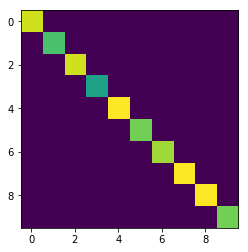

In [176]:
cm = confusion_matrix(xc_valid_preds, valid_batches.classes)
plt.imshow(cm)

In [ ]:
write_submission_file(test_probs=xc_test_probs,model_name='Xception', clip_value=0.00)

# 5. Stacking

### 5.2. Dense layer on Inception, Xception

In [177]:
ix_train = np.hstack([incept_bottleneck_features_train_cropped, xception_bottleneck_features_train_cropped])
ix_valid = np.hstack([incept_bottleneck_features_valid_cropped, xception_bottleneck_features_valid_cropped])
ix_test = np.hstack([incept_bottleneck_features_test_cropped, xception_bottleneck_features_test_cropped])

In [178]:
incept_bottleneck_features_train_cropped.shape, xception_bottleneck_features_train_cropped.shape, ix_train.shape

((1021, 2048), (1021, 2048), (1021, 4096))

In [185]:
opt= RMSprop(1e-4)
top_stack_model = Sequential([
        Dense(output_dim, activation='softmax',input_shape=ix_train.shape[1:])
        ])
top_stack_model.compile(optimizer= opt , loss='categorical_crossentropy', metrics=['accuracy'])
batch_size = 1

In [186]:
top_stack_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 10)                40970     
Total params: 40,970
Trainable params: 40,970
Non-trainable params: 0
_________________________________________________________________


In [187]:
ix_train.shape, train_labels.shape

((1021, 4096), (1021, 10))

In [188]:
history_top_stack = top_stack_model.fit(ix_train, train_labels, epochs = 200, batch_size = batch_size, 
                 validation_data = (ix_valid, valid_labels))

Train on 1021 samples, validate on 120 samples
Epoch 1/200
1021/1021 [==============================] - 2s - loss: 0.5035 - acc: 0.9099 - val_loss: 0.0289 - val_acc: 0.9917
Epoch 2/200
1021/1021 [==============================] - 2s - loss: 0.0525 - acc: 0.9853 - val_loss: 0.0108 - val_acc: 1.0000
Epoch 3/200
1021/1021 [==============================] - 2s - loss: 0.0499 - acc: 0.9853 - val_loss: 0.0069 - val_acc: 1.0000
Epoch 4/200
1021/1021 [==============================] - 2s - loss: 0.0517 - acc: 0.9843 - val_loss: 0.0073 - val_acc: 1.0000
Epoch 5/200
1021/1021 [==============================] - 2s - loss: 0.0496 - acc: 0.9863 - val_loss: 0.0063 - val_acc: 1.0000
Epoch 6/200
1021/1021 [==============================] - 2s - loss: 0.0553 - acc: 0.9833 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 7/200
1021/1021 [==============================] - 2s - loss: 0.0539 - acc: 0.9863 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 8/200
1021/1021 [==============================] - 2s - loss: 0.0

1021/1021 [==============================] - 2s - loss: 0.0613 - acc: 0.9892 - val_loss: 2.9556e-04 - val_acc: 1.0000
Epoch 127/200
1021/1021 [==============================] - 2s - loss: 0.0598 - acc: 0.9892 - val_loss: 3.2792e-04 - val_acc: 1.0000
Epoch 128/200
1021/1021 [==============================] - 2s - loss: 0.0619 - acc: 0.9892 - val_loss: 5.7232e-04 - val_acc: 1.0000
Epoch 129/200
1021/1021 [==============================] - 2s - loss: 0.0601 - acc: 0.9892 - val_loss: 3.7278e-04 - val_acc: 1.0000
Epoch 130/200
1021/1021 [==============================] - 2s - loss: 0.0582 - acc: 0.9892 - val_loss: 2.3779e-04 - val_acc: 1.0000
Epoch 131/200
1021/1021 [==============================] - 2s - loss: 0.0598 - acc: 0.9892 - val_loss: 2.2583e-04 - val_acc: 1.0000
Epoch 132/200
1021/1021 [==============================] - 2s - loss: 0.0595 - acc: 0.9892 - val_loss: 9.2777e-04 - val_acc: 1.0000
Epoch 133/200
1021/1021 [==============================] - 2s - loss: 0.0601 - acc: 0.9892

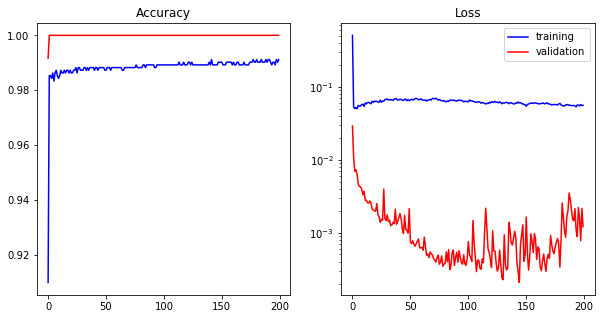

In [189]:
acc = history_top_stack.history['acc']
val_acc = history_top_stack.history['val_acc']
loss = history_top_stack.history['loss']
val_loss = history_top_stack.history['val_loss']
epochs = history_top_stack.epoch

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
ax = axes[0]
ax.plot(epochs, acc, 'b')
ax.plot(epochs, val_acc, 'r')
ax.set_title("Accuracy")

ax = axes[1]
ax.semilogy(epochs, loss, 'b', label = 'training')
ax.semilogy(epochs, val_loss, 'r', label = 'validation')
ax.set_title("Loss")
ax.legend(loc='upper right')

plt.show()

### predictions and submission file

In [190]:
# predicted classes
ix_test_preds = top_stack_model.predict_classes(ix_test, batch_size=batch_size)
ix_valid_preds = top_stack_model.predict_classes(ix_valid, batch_size=batch_size)

# probabilities of being in a given class
ix_test_probs = top_stack_model.predict_proba(ix_test, batch_size=batch_size)
ix_valid_probs = top_stack_model.predict_proba(ix_valid, batch_size=batch_size)

 67/120 [===============>..............] - ETA: 0s

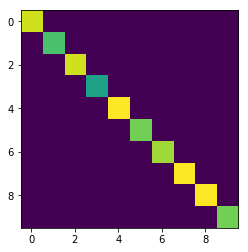

In [191]:
cm = confusion_matrix(ix_valid_preds, valid_batches.classes)
plt.imshow(cm)

In [785]:
write_submission_file(test_probs = ix_test_probs,model_name='XI', clip_value=0.00)

/home/gael/Bureau/kaggle/dog-breed-identification/data


# 6. Misclassified images from validation set

In [192]:
error_idx = (valid_batches.classes != ix_valid_preds)
wrong_img_idx = [i for i in range(len(error_idx)) if (error_idx[i] == 1)]
wrong_img_filenames = [valid_batches.filenames[wrong_img_idx[i]] for i in range(len(wrong_img_idx))]
true_breeds = [wrong_img_filenames[i][:wrong_img_filenames[i].find('/')] for i in range(len(wrong_img_idx))]
mispredicted_breeds = [sorted(valid_batches.class_indices.keys())[ix_valid_preds[wrong_img_idx[i]]] for i in range(len(wrong_img_idx))]

#error_idx = (valid_batches.classes != resnet_valid_preds)
#wrong_img_idx = [i for i in range(len(error_idx)) if (error_idx[i] == 1)]
#wrong_img_filenames = [valid_batches.filenames[wrong_img_idx[i]] for i in range(len(wrong_img_idx))]
#true_breeds = [wrong_img_filenames[i][:wrong_img_filenames[i].find('/')] for i in range(len(wrong_img_idx))]
#mispredicted_breeds = [sorted(valid_batches.class_indices.keys())[resnet_valid_preds[wrong_img_idx[i]]] for i in range(len(wrong_img_idx))]

In [193]:
len(mispredicted_breeds)

0

In [194]:
for i in range(len(wrong_img_idx)):
    fig, ax = plt.subplots(figsize=(5,5))
    img = image.load_img(path + 'valid/' + wrong_img_filenames[i], target_size=(299, 299))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.text(10, 250, 'Prediction: %s' % mispredicted_breeds[i], color='w', backgroundcolor='r')
    ax.text(10, 270, 'LABEL: %s' % true_breeds[i], color='k', backgroundcolor='g')
    ax.axis('off')
    plt.show()   

## Prediction from a test image

In [209]:
img_path = '/home/gael/Bureau/kaggle/dog-breed-identification/data/sample/valid/afghan_hound/77ca2e85e0e8ea05ad424b9e53e644f1.jpg'
#img_path = '/home/gael/Bureau/kaggle/dog-breed-identification/data/sample/valid/basenji/2c2a4f529131c3109a7ab66b133b8461.jpg'
#img_path = '/home/gael/Bureau/kaggle/dog-breed-identification/data/sample/valid/bernese_mountain_dog/1e5ce138280eabd214664398f19491b3.jpg'
#img_path = '/home/gael/Bureau/kaggle/dog-breed-identification/data/sample/valid/shih-tzu/b73df1ea118d708edd2dc6dd2bfa6b8d.jpg'
#img_path = '/home/gael/Bureau/kaggle/dog-breed-identification/data/sample/test/unknown/17db3d5f42821f3642a5c0cf87c19cdf.jpg'
#img_path = '/home/gael/Images/photos Tiffany/id/DSCF8678.JPG'

img = image.load_img(img_path, target_size=(299, 299))
#img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = xception.preprocess_input(x)
pred_img_feat_inception = conv_model_inception_v3.predict(x)
pred_img_feat_xception = conv_model_xception.predict(x)
im_test = np.hstack([pred_img_feat_inception, pred_img_feat_xception])
pred_img = top_stack_model.predict_classes(im_test)
#x = vgg16.preprocess_input(x)
#pred_img_feat_resnet = conv_model_resnet.predict(x)
#pred_img = top_model.predict_classes(pred_img_feat_resnet)

1/1 [==============================] - 0s


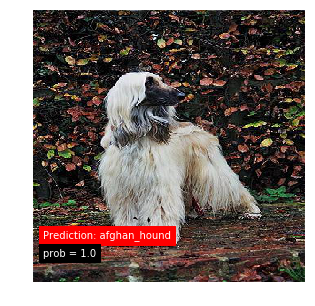

In [210]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(img)# / 255.)
ax.text(10, 250, 'Prediction: %s' % sorted(valid_batches.class_indices.keys())[int(pred_img)], color='w', backgroundcolor='r')
ax.text(10, 270, 'prob = %s' % str(np.max(top_stack_model.predict(im_test))), color='w', backgroundcolor='k')
#ax.text(10, 270, 'prob = %s' % str(np.max(top_model.predict(pred_img_feat_resnet))), color='w', backgroundcolor='k')
ax.axis('off')
plt.show()

---

In [26]:
_, valid_batches_display, _ = get_batches(224)

Found 1021 images belonging to 10 classes.
Found 120 images belonging to 10 classes.
Found 1035 images belonging to 1 classes.


In [27]:
valid_data_display = np.concatenate([valid_batches_display.next() for i in tqdm(range(valid_batches_display.n))])


100%|██████████| 120/120 [00:00<00:00, 290.86it/s]


In [41]:
idx_test = 7
img_test = valid_data_display[idx_test]

#fig, ax = plt.subplots(figsize=(5,5))
#ax.imshow((img_test - np.min(img_test))/np.max(img_test - np.min(img_test)))

#ax.imshow(img_test / 255.)
#plt.show() 

In [40]:
#Pool layer heatmap

#We have to add an extra dimension to our input since the CNN expects a 'batch' (even if it's just a batch of one).
inp = np.expand_dims(valid_data[idx_test], 0)

cm = conv_fn([inp,0])[0]
#plt.imshow(np.sum(cm[0], axis = 2), cmap="cool")

resized_pool_layer = scipy.misc.imresize(np.sum(cm[0], axis = 2), (224,224))#, interp='nearest')

#fig, ax = plt.subplots(figsize=(5,5))
#ax.imshow(resized_pool_layer, cmap = 'cool')
#plt.show() 

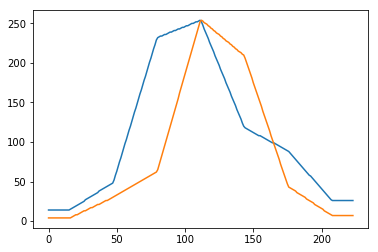

In [32]:
max_pos_vert = np.where(resized_pool_layer == np.max(resized_pool_layer))[0][0]
max_pos_horiz = np.where(resized_pool_layer == np.max(resized_pool_layer))[1][0]

plt.plot(resized_pool_layer[:,max_pos_horiz])
plt.plot(resized_pool_layer[max_pos_vert,:])

In [42]:
#cropped image

input_dim = 224#valid_data_500[idx_test].shape[1]
    #cropped_data = np.zeros((number_of_images, input_dim, input_dim, 3))
inp = np.expand_dims(valid_data[idx_test], 0)
    
        # colormap of last max pooling layer
cm = conv_fn([inp,0])[0]
resized_pool_layer = scipy.misc.imresize(np.sum(cm[0], axis = 2), (input_dim, input_dim))#, interp='nearest')
    
        # position of maximum in colormap
max_pos_vert = np.where(resized_pool_layer == np.max(resized_pool_layer))[0][0]
max_pos_horiz = np.where(resized_pool_layer == np.max(resized_pool_layer))[1][0]
    
        # lineouts across maximum 
horiz_lineout = resized_pool_layer[max_pos_vert,:]
vert_lineout = resized_pool_layer[:,max_pos_horiz]
        
        # define bounding box around maximum intensity of max pooling layer
threshold = 0.3 # for selecting bounding box around maximum

horiz_right = max_pos_horiz 
while horiz_right < input_dim :
    if (horiz_lineout[horiz_right] < np.int(threshold*np.max(horiz_lineout)) ): break
    horiz_right += 1
horiz_left = max_pos_horiz
while horiz_left > 0:
    if (horiz_lineout[horiz_left] < np.int(threshold*np.max(horiz_lineout)) ): break
    horiz_left -= 1

max_pos_vert = np.where(vert_lineout == np.max(vert_lineout))[0][0]
vert_top = max_pos_vert 
while vert_top > 0:
    if (vert_lineout[vert_top] < np.int(threshold*np.max(vert_lineout)) ): break
    vert_top -= 1
vert_bottom = max_pos_vert
while vert_bottom < input_dim:
    if (vert_lineout[vert_bottom] < np.int(threshold*np.max(vert_lineout)) ): break            
    vert_bottom += 1
        
valid_data_mod_test = img_test[vert_top:vert_bottom,horiz_left:horiz_right]
#plt.imshow(scipy.misc.imresize(valid_data_mod_test, (224,224))/255.)

---

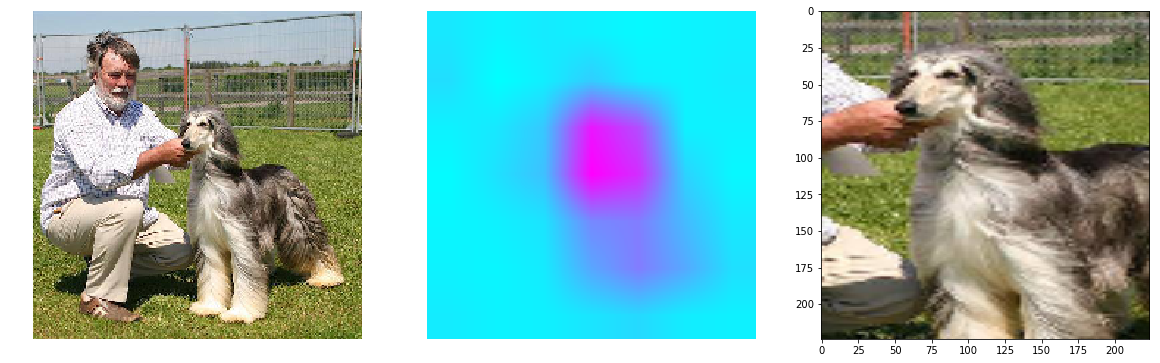

In [43]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows = 1, ncols = 3, figsize=(20,20))
ax0.imshow(img_test / 255.)
ax0.axis('off')
ax1.imshow(resized_pool_layer, cmap = 'cool')
ax1.axis('off')
ax2.imshow(scipy.misc.imresize(valid_data_mod_test, (224,224))/255.)